In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob

from datetime import datetime
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

In [2]:
# 读取所有 CSV 文件
file_list = glob.glob('../../data/Shopping/*.csv')

for i in range(len(file_list)):
    url = file_list[i]
    
    # 提取文件名（去掉路径）
    file_name = Path(file_list[i]).stem  # 获取 '2025.01.22'

    # 替换文件名中的 '.' 为 '-' (防止干扰日期解析)
    formatted_date = file_name.replace('.', '-')

    try:
        # 将格式化后的日期字符串转换为日期对象
        day = pd.to_datetime(formatted_date, format='%Y-%m-%d').day_name()
    except ValueError:
        day = 'Invalid Date'  # 如果解析失败，标记为无效日期

    # 存储到字典格式
    file_list[i] = {day: url}

print(file_list)

[{'Thursday': '../../data/Shopping/2025.01.23.csv'}, {'Friday': '../../data/Shopping/2025.01.24.csv'}, {'Saturday': '../../data/Shopping/2025.01.25.csv'}, {'Sunday': '../../data/Shopping/2025.01.26.csv'}]


# Workdays

In [3]:
# 按小时顺序排序（手动定义时间段顺序）
hour_order = [
    '12 am – 1 am', '1 am – 2 am', '2 am – 3 am', '3 am – 4 am',
    '4 am – 5 am', '5 am – 6 am', '6 am – 7 am', '7 am – 8 am',
    '8 am – 9 am', '9 am – 10 am', '10 am – 11 am', '11 am – 12 pm',
    '12 pm – 1 pm', '1 pm – 2 pm', '2 pm – 3 pm', '3 pm – 4 pm',
    '4 pm – 5 pm', '5 pm – 6 pm', '6 pm – 7 pm', '7 pm – 8 pm',
    '8 pm – 9 pm', '9 pm – 10 pm', '10 pm – 11 pm', '11 pm – 12 am'
]

Workdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

Workdays_list = [pd.read_csv(list(item.values())[0]) for item in file_list if list(item.keys())[0] in Workdays]
Workdays = pd.concat(Workdays_list, ignore_index=True)

# 处理 Impressions 列，转换为整数
Workdays['Impressions'] = pd.to_numeric(Workdays['Impressions'], errors='coerce').fillna(0).astype(int)

# 去掉"$"符号并转换为 float
Workdays['Avg. CPC'] = Workdays['Avg. CPC'].replace(r'[\$,]', '', regex=True).astype(float)
Workdays['Cost'] = Workdays['Cost'].replace(r'[\$,]', '', regex=True).astype(float)

# 确保小时的格式完整，不进行 24 小时转换
Workdays_grouped = Workdays.groupby('Hour').agg({
    'Clicks': 'mean',
    'Impressions': 'mean',
    'Avg. CPC': 'mean',
    'Cost': 'mean'
}).reset_index()

Workdays_grouped['Hour'] = pd.Categorical(Workdays_grouped['Hour'], categories=hour_order, ordered=True)
Workdays_grouped = Workdays_grouped.sort_values('Hour')

# 显示最终结果
print(Workdays_grouped)

             Hour  Clicks  Impressions  Avg. CPC   Cost
6    12 am – 1 am     0.0         30.5     0.000  0.000
0     1 am – 2 am     0.0         11.0     0.000  0.000
8     2 am – 3 am     0.0          9.5     0.000  0.000
10    3 am – 4 am     0.0          6.5     0.000  0.000
12    4 am – 5 am     0.0          7.0     0.000  0.000
14    5 am – 6 am     0.0         11.5     0.000  0.000
16    6 am – 7 am     1.0         39.0     2.600  5.200
18    7 am – 8 am     0.0         29.0     0.000  0.000
20    8 am – 9 am     0.0         40.5     0.000  0.000
22   9 am – 10 am     0.5         61.0     1.730  1.730
2   10 am – 11 am     0.0         40.5     0.000  0.000
4   11 am – 12 pm     0.5         75.0     0.255  0.255
7    12 pm – 1 pm     0.0         69.5     0.000  0.000
1     1 pm – 2 pm     1.0        100.5     1.880  3.760
9     2 pm – 3 pm     1.0        129.5     0.430  0.860
11    3 pm – 4 pm     1.5        157.5     4.285  4.385
13    4 pm – 5 pm     0.5        129.0     0.300

In [4]:
workdays_X = Workdays_grouped.drop(columns=['Hour']).reset_index(drop=True)
workdays_Y = Workdays_grouped['Hour'].reset_index(drop=True)

train_workdays_X, test_workdays_X, train_workdays_Y, test_workdays_Y = train_test_split(
    workdays_X, workdays_Y, test_size=0.2, random_state=42
)

scaler = MinMaxScaler(feature_range=(0, 1))
train_workdays_X = scaler.fit_transform(train_workdays_X)
train_workdays_X

array([[0.125     , 0.12960761, 0.40373396, 0.33269231],
       [0.25      , 0.2235434 , 0.43873979, 0.72307692],
       [0.        , 0.01070155, 0.        , 0.        ],
       [0.        , 0.12722949, 0.        , 0.        ],
       [0.        , 0.01189061, 0.        , 0.        ],
       [0.        , 0.00713436, 0.        , 0.        ],
       [0.        , 0.14982164, 0.        , 0.        ],
       [0.375     , 0.35909631, 1.        , 0.84326923],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00118906, 0.        , 0.        ],
       [0.125     , 0.16052319, 0.3663944 , 0.30192308],
       [0.875     , 0.882283  , 0.01166861, 0.06442308],
       [0.75      , 0.42925089, 0.24504084, 0.26346154],
       [0.125     , 0.10344828, 0.61026838, 0.50288462],
       [0.        , 0.05350773, 0.        , 0.        ],
       [0.        , 0.08085612, 0.        , 0.        ],
       [0.25      , 0.29250892, 0.10035006, 0.16538462],
       [1.        , 1.        ,

最佳 K 值: 3, 轮廓系数: 0.613


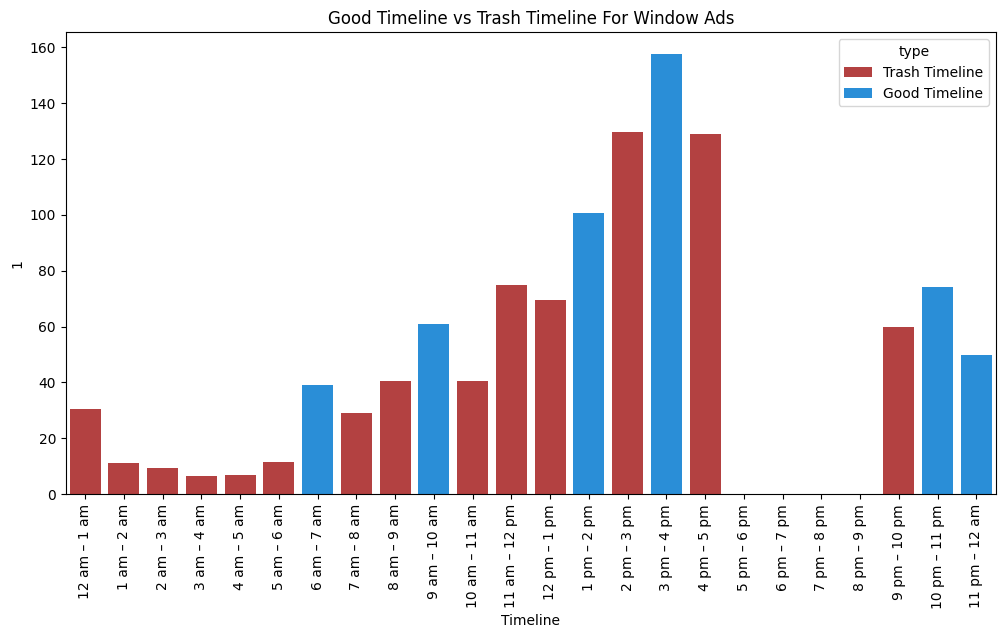

In [5]:
# 定义 K 值的搜索范围
param_grid = {'n_clusters': range(2, 10)}

best_k = None
best_score = -1

for params in ParameterGrid(param_grid):
    kmeans = KMeans(n_clusters=params['n_clusters'], random_state=42, n_init=10)
    labels = kmeans.fit_predict(train_workdays_X)
    score = silhouette_score(train_workdays_X, labels)
    
    if score > best_score:
        best_score = score
        best_k = params['n_clusters']

print(f"最佳 K 值: {best_k}, 轮廓系数: {best_score:.3f}")

# 使用最佳 K 值进行最终聚类（使用完整数据）
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)

# 在完整数据集上进行聚类预测
Workdays_grouped['Cluster'] = kmeans.fit_predict(scaler.transform(workdays_X))

# 映射聚类标签，0 代表垃圾时间段，1 代表优质时间段（示例，实际需检查）
Workdays_grouped['Cluster_Label'] = Workdays_grouped['Cluster'].map({0: 'Trash Timeline', 1: 'Good Timeline'})

# 按小时顺序排序
Workdays_grouped['Hour'] = pd.Categorical(Workdays_grouped['Hour'], categories=hour_order, ordered=True)
Workdays_grouped = Workdays_grouped.sort_values('Hour')

# 创建用于可视化的 DataFrame，设置所有值为1，便于条形图展示
Workdays_grouped['Value'] = Workdays_grouped['Impressions']

# 定义颜色映射，优质时间段为绿色，垃圾时间段为红色
color_map = {
    'Trash Timeline': '#C62E2E',
    'Good Timeline': '#0D92F4',
    
}

# 绘制条形统计图
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Hour', 
    y='Value', 
    hue='Cluster_Label', 
    data=Workdays_grouped, 
    palette=color_map,
    dodge=False  # 避免多分类偏移
)

# 美化图表
plt.xticks(rotation=90)
plt.title('Good Timeline vs Trash Timeline For Window Ads')
plt.xlabel('Timeline')
plt.ylabel('1')
plt.legend(title='type')
plt.show()

# Holidays

In [6]:
Holidays = ['Saturday', 'Sunday']

Holidays_list = [pd.read_csv(list(item.values())[0]) for item in file_list if list(item.keys())[0] in Holidays]
Holidays = pd.concat(Holidays_list, ignore_index=True)

# 处理 Impressions 列，转换为整数
Holidays['Impressions'] = pd.to_numeric(Holidays['Impressions'], errors='coerce').fillna(0).astype(int)

# 去掉"$"符号并转换为 float
Holidays['Avg. CPC'] = Holidays['Avg. CPC'].replace(r'[\$,]', '', regex=True).astype(float)
Holidays['Cost'] = Holidays['Cost'].replace(r'[\$,]', '', regex=True).astype(float)

# 确保小时的格式完整，不进行 24 小时转换
Holidays_grouped = Holidays.groupby('Hour').agg({
    'Clicks': 'mean',
    'Impressions': 'mean',
    'Avg. CPC': 'mean',
    'Cost': 'mean'
}).reset_index()

Holidays_grouped['Hour'] = pd.Categorical(Holidays_grouped['Hour'], categories=hour_order, ordered=True)
Holidays_grouped = Holidays_grouped.sort_values('Hour')

# 显示最终结果
print(Holidays_grouped)

             Hour  Clicks  Impressions  Avg. CPC   Cost
6    12 am – 1 am     1.0        103.5     1.115  2.225
0     1 am – 2 am     0.0         23.5     0.000  0.000
8     2 am – 3 am     0.0         13.0     0.000  0.000
10    3 am – 4 am     0.0          7.0     0.000  0.000
12    4 am – 5 am     0.0          5.0     0.000  0.000
14    5 am – 6 am     0.0         12.0     0.000  0.000
16    6 am – 7 am     0.0         19.0     0.000  0.000
18    7 am – 8 am     0.5         57.5     5.190  5.190
20    8 am – 9 am     0.0         30.0     0.000  0.000
22   9 am – 10 am     0.0         69.5     0.000  0.000
2   10 am – 11 am     0.0        166.5     0.000  0.000
4   11 am – 12 pm     0.5        268.5     0.685  0.685
7    12 pm – 1 pm     2.5        336.0     0.875  1.975
1     1 pm – 2 pm     0.0        255.5     0.000  0.000
9     2 pm – 3 pm     0.0        228.5     0.000  0.000
11    3 pm – 4 pm     1.0        234.5     0.040  0.080
13    4 pm – 5 pm     0.5        198.0     0.065

In [7]:
Holidays_X = Holidays_grouped.drop(columns=['Hour']).reset_index(drop=True)
Holidays_Y = Holidays_grouped['Hour'].reset_index(drop=True)

train_holidays_X, test_holidays_X, train_holidays_Y, test_holidays_Y = train_test_split(
    Holidays_X, Holidays_Y, test_size=0.2, random_state=42
)

scaler = MinMaxScaler(feature_range=(0, 1))
train_holidays_X = scaler.fit_transform(train_holidays_X)
train_holidays_X

array([[0.        , 0.19486405, 0.        , 0.        ],
       [0.        , 0.75679758, 0.        , 0.        ],
       [0.        , 0.05589124, 0.        , 0.        ],
       [0.        , 0.79909366, 0.        , 0.        ],
       [0.        , 0.02114804, 0.        , 0.        ],
       [0.        , 0.02416918, 0.        , 0.        ],
       [1.        , 1.        , 0.16859345, 0.3805395 ],
       [0.4       , 0.69335347, 0.00770713, 0.01541426],
       [0.        , 0.0060423 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.8       , 0.44712991, 0.07321773, 0.29190751],
       [0.2       , 0.64350453, 0.02312139, 0.02312139],
       [0.        , 0.48640483, 0.        , 0.        ],
       [0.        , 0.09365559, 0.        , 0.        ],
       [0.2       , 0.15861027, 1.        , 1.        ],
       [0.        , 0.48791541, 0.        , 0.        ],
       [0.        , 0.67522659, 0.        , 0.        ],
       [0.        , 0.34592145,

最佳 K 值: 4, 轮廓系数: 0.596


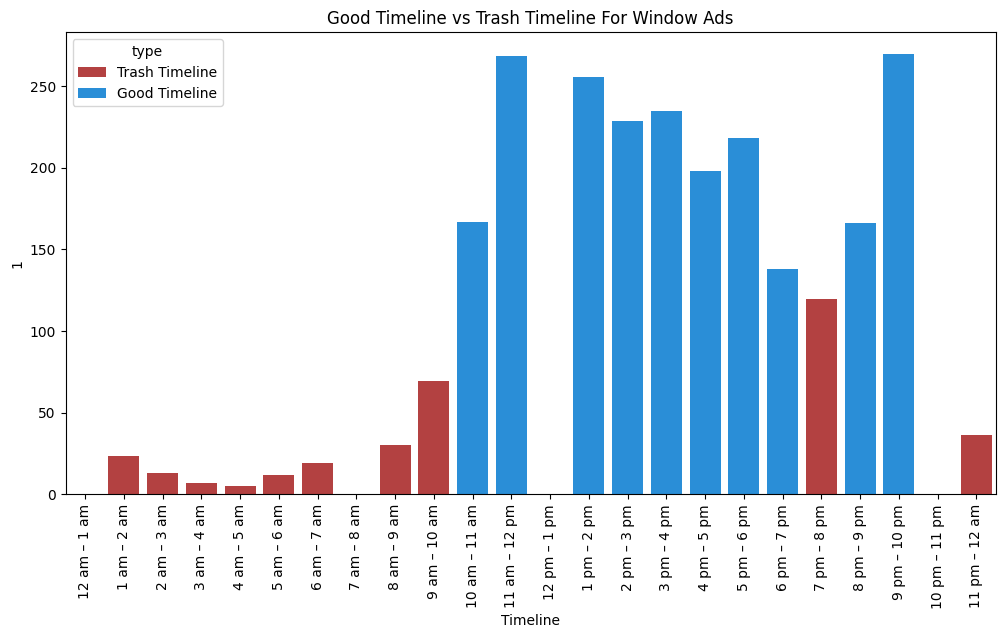

In [8]:
# 定义 K 值的搜索范围
param_grid = {'n_clusters': range(2, 10)}

best_k = None
best_score = -1

for params in ParameterGrid(param_grid):
    kmeans = KMeans(n_clusters=params['n_clusters'], random_state=42, n_init=10)
    labels = kmeans.fit_predict(train_holidays_X)
    score = silhouette_score(train_holidays_X, labels)
    
    if score > best_score:
        best_score = score
        best_k = params['n_clusters']

print(f"最佳 K 值: {best_k}, 轮廓系数: {best_score:.3f}")

# 使用最佳 K 值进行最终聚类（使用完整数据）
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)

# 在完整数据集上进行聚类预测
Holidays_grouped['Cluster'] = kmeans.fit_predict(scaler.transform(Holidays_X))

# 映射聚类标签，0 代表垃圾时间段，1 代表优质时间段（示例，实际需检查）
Holidays_grouped['Cluster_Label'] = Holidays_grouped['Cluster'].map({0: 'Trash Timeline', 1: 'Good Timeline'})

# 按小时顺序排序
Holidays_grouped['Hour'] = pd.Categorical(Holidays_grouped['Hour'], categories=hour_order, ordered=True)
Holidays_grouped = Holidays_grouped.sort_values('Hour')

# 创建用于可视化的 DataFrame，设置所有值为1，便于条形图展示
Holidays_grouped['Value'] = Holidays_grouped['Impressions']

# 定义颜色映射，优质时间段为绿色，垃圾时间段为红色
color_map = {
    'Good Timeline': '#0D92F4',
    'Trash Timeline': '#C62E2E'
}

# 绘制条形统计图
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Hour', 
    y='Value', 
    hue='Cluster_Label', 
    data=Holidays_grouped, 
    palette=color_map,
    dodge=False  # 避免多分类偏移
)

# 美化图表
plt.xticks(rotation=90)
plt.title('Good Timeline vs Trash Timeline For Window Ads')
plt.xlabel('Timeline')
plt.ylabel('1')
plt.legend(title='type')
plt.show()